In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
random_seed = 42

In [3]:
device = qml.device("default.qubit", wires=4)

## Load IRIS Dataset

In [4]:
iris_dataset = np.loadtxt("iris.txt")
X, Y = iris_dataset[:, 0: 4], iris_dataset[:, -1]
Y[Y < 0] = 0
print(f"First sample: {X[0]}")
print(f"Label = {int(Y[0])}")

First sample: [0.4  0.75 0.2  0.05]
Label = 0


## Normalize Data

In [5]:
X_norm = 1. * np.pi * np.array([x / np.linalg.norm(x, requires_grad=False) for x in X], requires_grad=False)
print("First sample normalized:", X_norm[0])

First sample normalized: [1.43674319 2.69389348 0.71837159 0.1795929 ]


## Split Data

In [6]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X_norm, Y, train_size=0.74, random_state=random_seed, stratify = Y)#X_train,X_val

In [7]:
X_tr_viz, X_te_viz,_,_ = train_test_split(X, Y, train_size=0.74, random_state=random_seed, stratify = Y)# X0_train,X0_val

In [8]:
Y_tr[Y_tr==1].shape,Y_tr[Y_tr==0].shape

((37,), (37,))

In [9]:
Y_te[Y_te==1].shape,Y_te[Y_te==0].shape

((13,), (13,))

## Quantum Circuit Definition

In [10]:
def feature_map(n_qubit,x):
    for i in range(n_qubit):
        qml.RZ(x[i], wires=i)
    for i in range(n_qubit):
        for j in range(i):
            qml.CNOT(wires=[j, i])
            qml.RZ(x[i]*x[j], wires=i)
            qml.CNOT(wires=[j, i])

def variational(layer,n_qubit,params): 
    for i in range(n_qubit):
        for j in range(i):
            qml.CNOT(wires=[j, i])    
    for i in range(n_qubit):
        qml.RY(params[layer+1][i], wires=i)        

In [11]:
def feature_map_circuit(layers,n_qubit,x):
    for q in range(n_qubit):
        qml.Hadamard(wires=q)    
    for layer in range(layers):
            feature_map(n_qubit,x)    
def variational_circuit(layers,n_qubit,params):
    for i in range(n_qubit):
        qml.RY(params[0][i], wires=i)
    for layer in range(layers):
            variational(layer,n_qubit,params)  

In [12]:
@qml.qnode(device)
def qnn(weights: np.ndarray, x = None):
    layers = weights.shape[0] - 1
    n_qubit = weights.shape[1]    

    for layer in range(layers):
        for q in range(n_qubit):
            qml.Hadamard(wires=q)
        feature_map(n_qubit,x)    
        qml.Barrier(wires=[0,1,2,3], only_visual=True) 
        variational_circuit(1,n_qubit,weights) 
        qml.Barrier(wires=[0, 1, 2, 3], only_visual=True)
    
    
    qml.Barrier(wires=[0, 1, 2, 3], only_visual=True)
    
    return qml.expval(qml.PauliZ(0))

## Metrics

In [13]:
def metrics_results(predictions, Y_true):
    print(confusion_matrix(Y_true, predictions))
    print(classification_report(Y_true, predictions))

## Quntum Circuit Hyperparameters Setting

In [14]:
s_in = len(X[0]) #num_qubits
depth = 2       #num_layers

### Print Quantum Circuit

In [15]:
@qml.qnode(device)
def print_circuit(circuit, parameters, **kwargs):
    circuit(parameters, **kwargs)
    return qml.state()

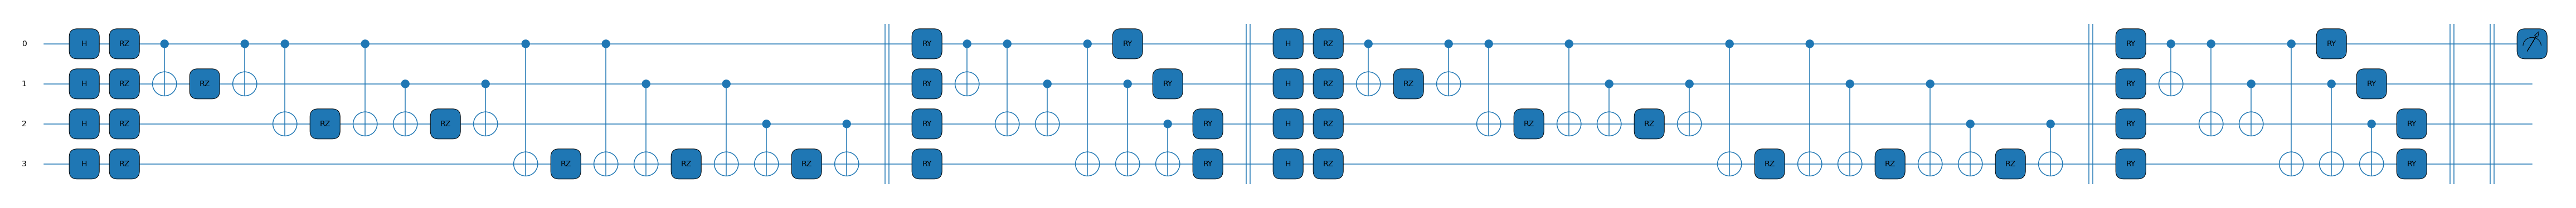

In [16]:
w_example = np.zeros((depth + 1, s_in))
x_example = X[0]
qml.draw_mpl(qnn)(weights = w_example, x = x_example);

## Accuracy and Cost Definition

In [17]:
def accuracy(Y, Y_pred, treshold = 0.9):
    Y_pred = (Y_pred + 1 - bias)/2
    Y_pred = np.where(Y_pred > 0.5, 1, 0)
    acc = np.sum(np.abs(Y - Y_pred) < treshold)
    return acc / len(Y)

def cost(weights, bias, X = None, Y = None):
    Y_pred = np.array([qnn(weights = weights, x = x) + bias for x in X])
    Y_pred = (Y_pred + 1 - bias)/2
    loss = np.sum((Y - Y_pred)**2) / len(Y)
    return loss

def BinaryCrossEntropy(weights, bias, X = None, Y = None):
    y_pred = np.array([qnn(weights, x = x) + bias for x in X]) #prediction
    y_pred = (y_pred + 1 - bias)/2 #normalizazion \in [0,1]
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-Y) * np.log(1-y_pred + 1e-7)
    term_1 = Y * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

## Hyperparameters Setting

In [18]:
np.random.seed(random_seed)
weights = 2 * np. pi * np.random.rand(depth + 1, s_in, requires_grad=True)

In [19]:
bias = np.array(0.0, requires_grad=True)

In [20]:
opt = qml.AdamOptimizer(0.1)

In [21]:
batch_size = len(X_tr)
max_iterations = 35

## Quantum Neural Network

In [22]:
loss_history = []
params_history = [[weights, bias]]

In [23]:
for step in range(max_iterations):
    # Take a batch of data
    batch_index = np.random.randint(0, len(X_tr), (batch_size,))
    X_tr_batch = X_tr[batch_index]
    Y_tr_batch = Y_tr[batch_index]
    
    # Perform a gradient update step
    (weights, bias), loss = opt.step_and_cost(BinaryCrossEntropy, weights, bias, X=X_tr_batch, Y=Y_tr_batch)  

    Y_pred = np.array([qnn(weights=weights, x=x) + bias for x in X_tr], requires_grad = False)
    acc_train = accuracy(Y_tr, Y_pred).numpy()
    Y_pred = np.array([qnn(weights=weights, x=x) + bias for x in X_te], requires_grad = False)
    acc_val = accuracy(Y_te, Y_pred).numpy()
    
    params_history.append([weights.numpy(), bias.numpy()])
    loss_history.append([loss.numpy(), acc_train, acc_val])
    
    print("Step: {:5d} | Cost: {:0.7f} | Acc. train: {:0.7f} | Acc. validation: {:0.7f} """.format(step + 1, loss, acc_train, acc_val))

# Saving intermediate results to numpy arrays for convenience
loss_history = np.array(loss_history, requires_grad=False)
params_history = np.array(params_history, dtype='object', requires_grad=False)

Step:     1 | Cost: 0.8172440 | Acc. train: 0.4594595 | Acc. validation: 0.4230769 
Step:     2 | Cost: 0.7597187 | Acc. train: 0.5675676 | Acc. validation: 0.5000000 
Step:     3 | Cost: 0.6774890 | Acc. train: 0.6756757 | Acc. validation: 0.5769231 
Step:     4 | Cost: 0.5943072 | Acc. train: 0.7297297 | Acc. validation: 0.6153846 
Step:     5 | Cost: 0.6454828 | Acc. train: 0.7972973 | Acc. validation: 0.7307692 
Step:     6 | Cost: 0.5854862 | Acc. train: 0.8108108 | Acc. validation: 0.8076923 
Step:     7 | Cost: 0.5701366 | Acc. train: 0.8243243 | Acc. validation: 0.8461538 
Step:     8 | Cost: 0.5422453 | Acc. train: 0.8513514 | Acc. validation: 0.8461538 
Step:     9 | Cost: 0.5199240 | Acc. train: 0.8513514 | Acc. validation: 0.8461538 
Step:    10 | Cost: 0.5194059 | Acc. train: 0.8243243 | Acc. validation: 0.8461538 
Step:    11 | Cost: 0.5275686 | Acc. train: 0.7972973 | Acc. validation: 0.8846154 
Step:    12 | Cost: 0.5040295 | Acc. train: 0.8243243 | Acc. validation: 0.8

c:\users\stefa\appdata\local\programs\python\python37\lib\site-packages\autograd\numpy\numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


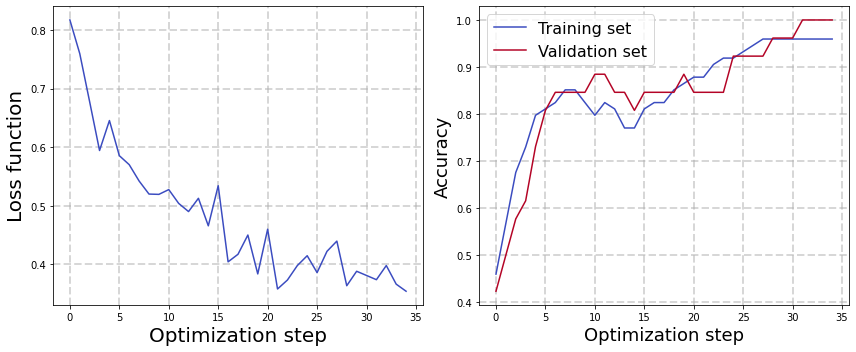

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# LOSS MINIMIAZTION PLOT
ax1.set_ylabel("Loss function", fontsize=20)
ax1.set_xlabel("Optimization step", fontsize=20)
ax1.grid(alpha=0.5, lw=2, ls='--')
ax1.plot(loss_history[:, 0], color=cm.coolwarm(0))

# ACCURAY PLOT
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Optimization step", fontsize=18)
ax2.grid(alpha=0.5, lw=2, ls='--')
ax2.plot(loss_history[:, 1], color=cm.coolwarm(0), label="Training set")
ax2.plot(loss_history[:, 2], color=cm.coolwarm_r(0), label = "Validation set")
ax2.legend(fontsize = 16)

plt.tight_layout()
plt.show()

In [25]:
best_step = np.argmin(loss_history, axis=0)[0]+1
best_weights = params_history[best_step][0]
best_bias = params_history[best_step][1]
best_step

tensor(35, requires_grad=False)

In [26]:
test_predictions = np.array([qnn(weights=best_weights, x=x) + best_bias for x in X_te])
test_predictions = (test_predictions + 1 - bias)/2
test_predictions = np.where(test_predictions > 0.5, 1, 0)
metrics_results(test_predictions, Y_te)

[[13  0]
 [ 0 13]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        13

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



## Plot Regions

In [27]:
def plot_2d(i,j):
    fig = plt.figure(figsize=(10,8))
    cm2 = plt.cm.coolwarm_r
    
    # Create grid points to show decision boundaries
    fi = np.mean(X_norm[:, i])
    fj = np.mean(X_norm[:, j])
    
    X_grid = []
    xx, yy = np.meshgrid(np.linspace(0.0, np.pi, 20), np.linspace(0.0, np.pi, 20))
    for x, y in zip(xx.flatten(), yy.flatten()):
        index_list = [0,1,2,3]
        index_list = [fi if il == i else il for il in index_list]
        index_list = [fj if il == j else il for il in index_list]
        index_xy = set(index_list)-set([fi,fj])
        index_list = [x if il == min(index_xy) else il for il in index_list]
        index_list = [y if il == max(index_xy) else il for il in index_list]
        X_grid.append(np.array(index_list))

    predictions_grid = np.array([qnn(weights=best_weights, x=x) + best_bias for x in X_grid])
    Z = np.reshape((predictions_grid-0.5)*2, xx.shape)
    
    # Plot decision regions
    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm2, alpha=0.8, extend="both")
    plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 0, 1])
    
    # Plot data
    f1 = min(set([0,1,2,3])-set([i,j]))
    f2 = max(set([0,1,2,3])-set([i,j]))
    # Iris class 1
    plt.scatter(X_tr[:, f1][Y_tr == 1], X_tr[:, f2][Y_tr == 1], c="b",marker="o", edgecolors="k", label="Class 1 - Training set")
    plt.scatter(X_te[:, f1][Y_te == 1], X_te[:, f2][Y_te == 1], c="b", marker="^", edgecolors="k", label="Class 1 - Validation set")

    # Iris class 2
    plt.scatter(X_tr[:, f1][Y_tr == 0], X_tr[:, f2][Y_tr == 0], c="r", marker="o", edgecolors="k", label="Class -1 - Training set")
    plt.scatter(X_te[:, f1][Y_te == 0], X_te[:, f2][Y_te == 0], c="r", marker="^", edgecolors="k", label="Class -1 - Validation Set")

    plt.plot([], [], lw = 0, label = f"Feature {i} = {np.round(fi,3)}")
    plt.plot([], [], lw = 0, label = f"Feature {j} = {np.round(fj,3)}")
    plt.ylabel(f"Feature {f1}", fontsize = 18)
    plt.xlabel(f"Feature {f2}", fontsize=18)

    plt.legend()
    plt.show()
    

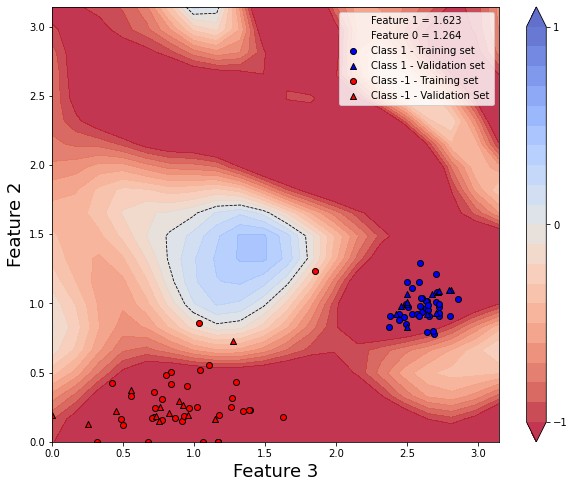

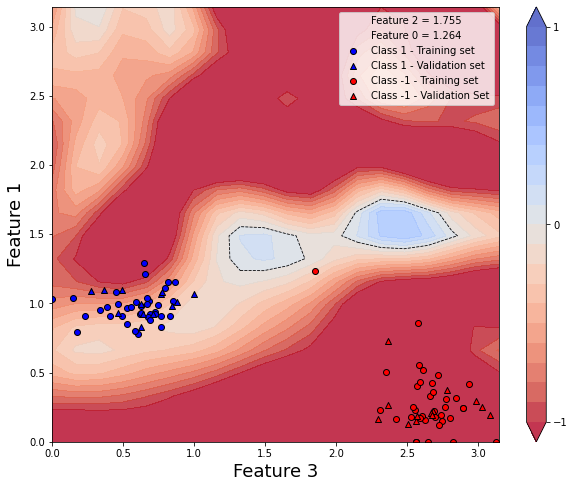

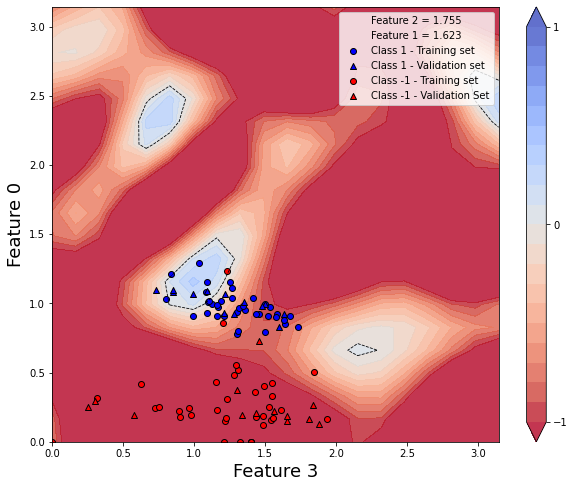

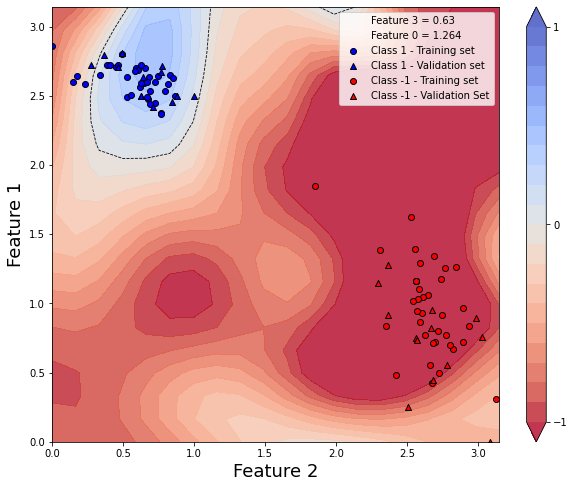

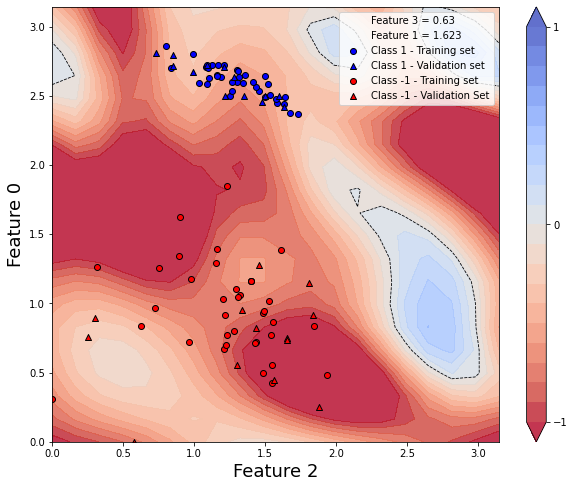

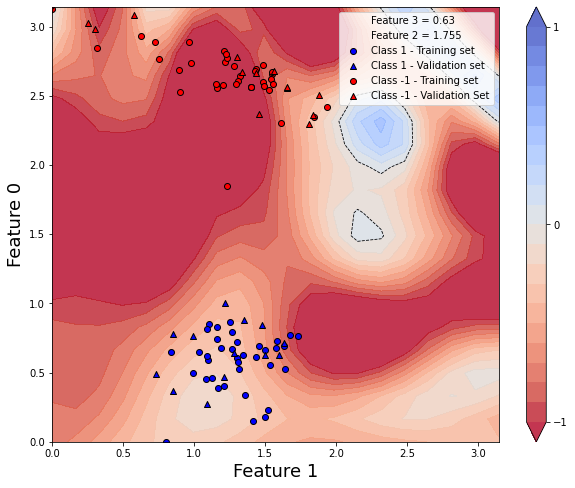

In [28]:
for i in range(4):
    for j in range(i):
        plot_2d(i,j)

## Save best_weights and best_bias

np.save('best_weights_bias.npy', best_weights)
np.save('data.npy', best_bias)

np.load('best_weights_bias.npy'),np.load('data.npy')